This notebook presents a step-by-step tutorial on using the developed packages for price forecasting.

In [93]:
# Add package folder to Python path
import sys
sys.path.append('./')
import forecasting as fr
import importlib
import pandas as pd
importlib.reload(fr.get_data)
importlib.reload(fr.model)
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib.dates as mdates

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_percentage_error

import tensorflow as tf
import optuna


## Data acquisition

Import the data as a dataframe. The helper function cleans up the data from API and only gives price and volume data.

NG ESO API - The API is *inclusive* of start date and *exclusive* of the end date.

In [76]:
query_start_date = '2024-06-10'
query_end_date = '2025-06-10'

dcl_data = fr.get_data.get_historical_fr_data_price_volume(query_start_date, query_end_date)

In [77]:
dcl_data.head()

,clearingPrice,clearedVolume
deliveryStart,,
2024-08-21 23:00:00,2.00,1261.0
2024-08-22 03:00:00,2.13,1366.0
2024-08-22 07:00:00,4.35,1207.0
2024-08-22 11:00:00,1.51,1176.0
2024-08-22 15:00:00,2.31,1177.0


## Naive forecast

In [97]:
# Calculate the naive forecast using a rolling average for both price and volume
# Give the data for days -1 (index -7 onwards) to -8 (until index -49) and verify the forecast for day 0.

price_naive_forecast = fr.model.rolling_average_multi_timeperiod(7, 6, dcl_data['clearingPrice'].iloc[:-6])
volume_naive_forecast = fr.model.rolling_average_multi_timeperiod(7, 6, dcl_data['clearedVolume'].iloc[:-6])

# Compare the naive forecast with the actual values for day 0
# Calculate the MAPE
mape_price_naive = mean_absolute_percentage_error(dcl_data['clearingPrice'].iloc[-6:], price_naive_forecast)
mape_volume_naive = mean_absolute_percentage_error(dcl_data['clearedVolume'].iloc[-6:], volume_naive_forecast)

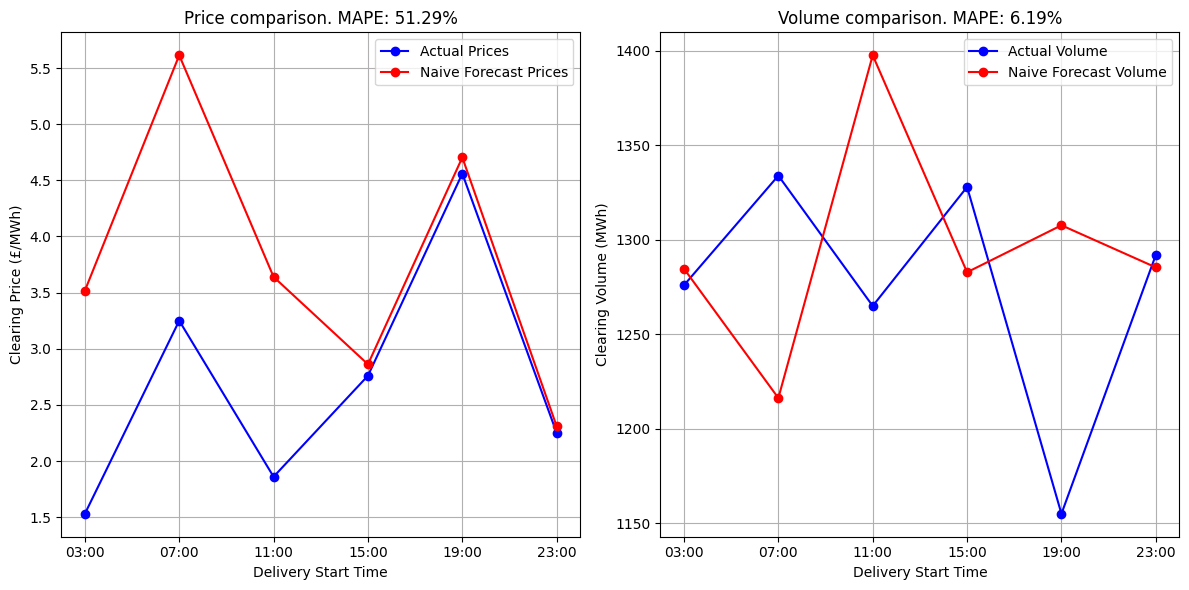

In [79]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

timestamp = dcl_data.index[-6:]

# First the price plot
ax1.plot(timestamp, dcl_data['clearingPrice'].iloc[-6:], marker='o', linestyle='-', color='blue', label='Actual Prices')
ax1.plot(timestamp, price_naive_forecast, marker='o', linestyle='-', color='red', label='Naive Forecast Prices')

ax1.set_xlabel('Delivery Start Time')
ax1.set_ylabel('Clearing Price (£/MWh)')
ax1.set_title('Price comparison. MAPE: {:.2f}%'.format(mape_price_naive * 100))
ax1.legend()

ax1.set_xticks(timestamp) # Shows ticks only at actual data points
ax1.set_xticklabels(timestamp.strftime("%H:%M"), rotation=0) # Shows only the hour and minute
ax1.grid(True)

# Next the volume plot
ax2.plot(timestamp, dcl_data['clearedVolume'].iloc[-6:], marker='o', linestyle='-', color='blue', label='Actual Volume')
ax2.plot(timestamp, volume_naive_forecast, marker='o', linestyle='-', color='red', label='Naive Forecast Volume')

ax2.set_xlabel('Delivery Start Time')
ax2.set_ylabel('Clearing Volume (MWh)')
ax2.set_title('Volume comparison. MAPE: {:.2f}%'.format(mape_volume_naive * 100))
ax2.legend()
ax2.set_xticks(timestamp) # Shows ticks only at actual data points
ax2.set_xticklabels(timestamp.strftime("%H:%M"), rotation=0) # Shows only the hour and minute
ax2.grid(True)


plt.tight_layout()
plt.show()

The naive forecast is... well... naive. It gives an error of over 51% for the prices which is quite rubbish. It's also worth noting from the above figure that the predictions are very much off for the first three time-steps, but quite good for the last three timesteps.

The forecast is quite accurate for volume prediction, however.

Time to use a deep learning model.

## Forecasting using LSTM

Autocorrelation analysis (in a different notebook) suggests that the time-series data has a good correlation with lags of 6, 12, and 18 timesteps. So we use that to generate lagged features for our LSTM model.

In [80]:
lag_times = [6, 12, 18]

# Create lagged features for the specified lag times
for lag in lag_times:
    dcl_data[f'Price_lag_{lag}'] = dcl_data['clearingPrice'].shift(lag)
    # dcl_data[f'Volume_lag_{lag}'] = dcl_data['clearedVolume'].shift(lag)

# Just one lag for volume
dcl_data[f'Volume_lag_{6}'] = dcl_data['clearedVolume'].shift(6)

print("Lagged features created for both price and volume lags:", lag_times)

# Drop rows that don't have enough history for the lagged features
dcl_data = dcl_data.dropna()

# print("First few rows of the dataframe are: \n", dcl_data.head())
# print("Last few rows of the dataframe are: \n", dcl_data.tail())

Lagged features created for both price and volume lags: [6, 12, 18]


In [81]:
# Split the dataset into training and validation sets
# Removing the data for the last day since that will be used for prediction
tscv = TimeSeriesSplit(n_splits=2)
for train_index, test_index in tscv.split(dcl_data.iloc[0:-6, :]):
    X_train, X_valid = dcl_data.iloc[train_index], dcl_data.iloc[test_index]

print("Train shape:", X_train.shape, "Validation shape:", X_valid.shape)
print("Original data shape:", dcl_data.shape)

Train shape: (1444, 6) Validation shape: (722, 6)
Original data shape: (2172, 6)


In [82]:
X_valid.tail()

,clearingPrice,clearedVolume,Price_lag_6,Price_lag_12,Price_lag_18,Volume_lag_6
deliveryStart,,,,,,
2025-06-08 07:00:00,1.53,1347.0,4.87,4.87,3.21,1333.0
2025-06-08 11:00:00,1.42,1350.0,2.00,3.13,6.22,1289.0
2025-06-08 15:00:00,3.18,1429.0,2.70,2.72,2.00,1421.0
2025-06-08 19:00:00,5.69,1272.0,4.89,3.61,4.71,1266.0
2025-06-08 23:00:00,1.65,1252.0,4.86,1.70,2.64,1313.0


In [83]:
# Define the LSTM parameters
WINDOW_SIZE = 24
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000
FORECAST_HORIZON = 6

In [84]:
# Generate the dataset windows that go into the LSTM model

series_train = X_train['clearingPrice'].values
X_lag_train = X_train.drop(columns=['clearingPrice', 'clearedVolume']).values
series_train = tf.convert_to_tensor(series_train, dtype=tf.float32)
X_lag_train = tf.convert_to_tensor(X_lag_train, dtype=tf.float32)

series_valid = X_valid['clearingPrice'].values
X_lag_valid = X_valid.drop(columns=['clearingPrice', 'clearedVolume']).values
series_valid = tf.convert_to_tensor(series_valid, dtype=tf.float32)
X_lag_valid = tf.convert_to_tensor(X_lag_valid, dtype=tf.float32)

train_set = fr.model.windowed_dataset_multi_input(
    series=series_train,
    X_lag_full=X_lag_train,
    window_size=WINDOW_SIZE,
    forecast_horizon=FORECAST_HORIZON,
    batch_size=BATCH_SIZE,
    shuffle_buffer=SHUFFLE_BUFFER_SIZE
)

valid_set = fr.model.windowed_dataset_multi_input(
    series=series_valid,
    X_lag_full=X_lag_valid,
    window_size=WINDOW_SIZE,
    forecast_horizon=FORECAST_HORIZON,
    batch_size=BATCH_SIZE,
    shuffle_buffer=SHUFFLE_BUFFER_SIZE
)

In [85]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Get the LSTM model
lstm_model = fr.model.get_LSTM_model(
    window_size= WINDOW_SIZE,  
    learning_rate= 1e-6, 
    momentum= 0.9, 
    num_lag_features= dcl_data.shape[1] - 2)
print(lstm_model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ sequence input      │ (None, 24, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 24, 64)    │        256 │ sequence          │
│                     │                   │            │ input[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 24, 64)    │     33,024 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lag input           │ (None, 4)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 64)        │     33,024 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │        320 │ lag input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128)       │          0 │ lstm_1[0][0],     │
│ (Concatenate)       │                   │            │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 6)         │        390 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 75,270 (294.02 KB)

 Trainable params: 75,270 (294.02 KB)

 Non-trainable params: 0 (0.00 B)

None


In [86]:
# Train the model


# Get initial weights
init_weights = lstm_model.get_weights()

# Reset the weights
lstm_model.set_weights(init_weights)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience= 10,
    restore_best_weights=True
)

# Fit the model
history = lstm_model.fit(
    train_set,
    epochs=100,
    validation_data=valid_set,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100
     42/Unknown 1s 9ms/step - loss: 44.8599 - mae: 45.3570

/Users/prashant/Dropbox/Training/DS_SP/Core_DS_Projects/.venv/lib/python3.9/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 43.7065 - mae: 44.2033 - val_loss: 10.3116 - val_mae: 10.7861
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.8013 - mae: 7.2589 - val_loss: 2.1387 - val_mae: 2.5963
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.2794 - mae: 1.6865 - val_loss: 1.9609 - val_mae: 2.4073
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.2047 - mae: 1.5983 - val_loss: 1.9757 - val_mae: 2.4224
Epoch 5/100
19/45 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0341 - mae: 1.4233

2025-07-22 14:47:32.724453: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.2013 - mae: 1.5948 - val_loss: 1.9739 - val_mae: 2.4206
Epoch 6/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.2007 - mae: 1.5941 - val_loss: 1.9731 - val_mae: 2.4197
Epoch 7/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.2002 - mae: 1.5936 - val_loss: 1.9724 - val_mae: 2.4190
Epoch 8/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.1997 - mae: 1.5932 - val_loss: 1.9716 - val_mae: 2.4182
Epoch 9/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.1993 - mae: 1.5928 - val_loss: 1.9698 - val_mae: 2.4164
Epoch 10/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.1989 - mae: 1.5924 - val_loss: 1.9668 - val_mae: 2.4132
Epoch 11/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.1985 - mae: 1.5920 - val_loss: 1.9630 - val_mae: 2.4093
Epoch 12/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.1982 - mae: 1.5917 - val_loss: 1.9602 - val_mae: 2.4062
Epoch 13/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.19

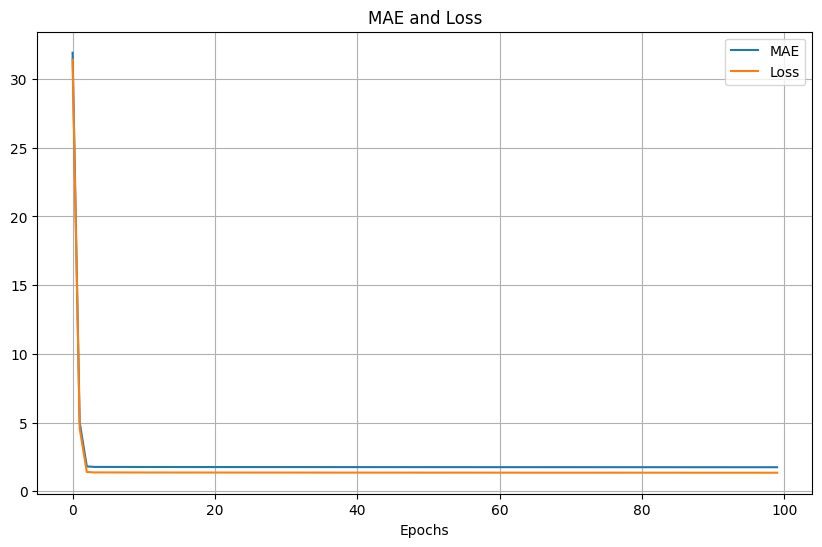

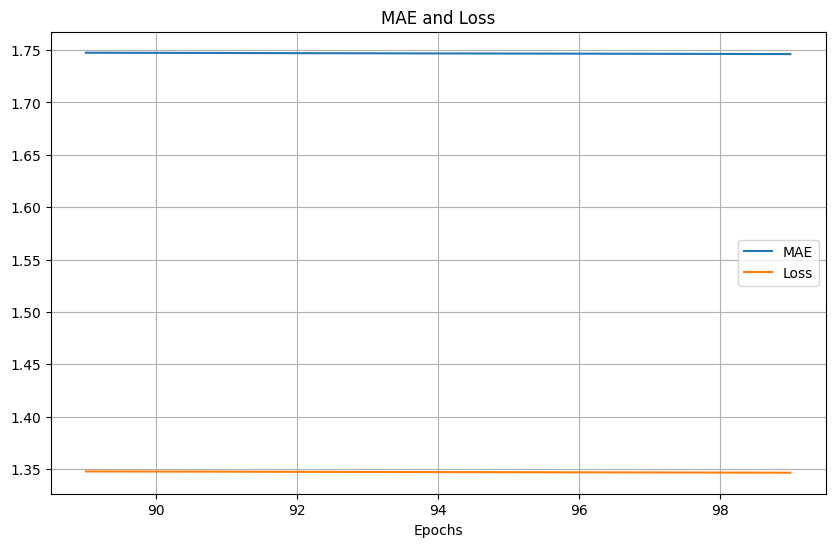

In [87]:
# Check if the training was successful by visualising the training history

# Get mae and loss from history log
mae=history.history['mae']
loss=history.history['loss']

# Get number of epochs
epochs=range(len(loss)) 

# Plot mae and loss
fr.get_data.plot_series(
    x=epochs, 
    y=(mae, loss), 
    title='MAE and Loss', 
    xlabel='Epochs',
    legend=['MAE', 'Loss']
    )


# Only plot the last 10% of the epochs
zoom_split = int(epochs[-1] * 0.9)
epochs_zoom = epochs[zoom_split:]
mae_zoom = mae[zoom_split:]
loss_zoom = loss[zoom_split:]

# Plot zoomed mae and loss
fr.get_data.plot_series(
    x=epochs_zoom, 
    y=(mae_zoom, loss_zoom), 
    title='MAE and Loss', 
    xlabel='Epochs',
    legend=['MAE', 'Loss']
    )


In [88]:
lstm_forecast = fr.model.lstm_forecast_multi_input(
    model=lstm_model,
    series=series_valid,
    X_lag_full=X_lag_valid,
    window_size=WINDOW_SIZE,
    forecast_horizon=FORECAST_HORIZON,
    batch_size=BATCH_SIZE
)

In [89]:
# Calculate the MAPE for the forecast for the last day (6 periods)
mape_forecast = mean_absolute_percentage_error(
    dcl_data['clearingPrice'].iloc[-6:],
    lstm_forecast[-1]
)  
print(f"MAPE for LSTM forecast: {mape_forecast*100:.2f}%")

print(f"MAPE for naive forecast was: {mape_price_naive*100:.2f}%")

MAPE for LSTM forecast: 39.93%
MAPE for naive forecast was: 51.29%


As we see with the results above, the LSTM predictions are significantly better than the naive forecast.

Next, visualise this performance.

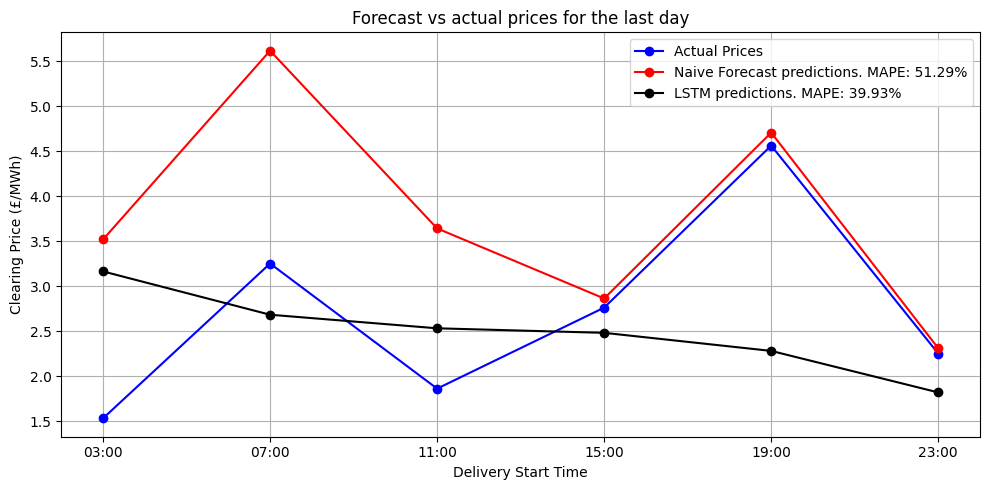

In [90]:
fig, ax1 = plt.subplots(1, 1, figsize=(10, 5))

timestamp = dcl_data.index[-6:]

# First the price plot
ax1.plot(timestamp, dcl_data['clearingPrice'].iloc[-6:], marker='o', linestyle='-', color='blue', label='Actual Prices')
ax1.plot(timestamp, price_naive_forecast, marker='o', linestyle='-', color='red', label='Naive Forecast predictions. MAPE: {:.2f}%'.format(mape_price_naive * 100))
ax1.plot(timestamp, lstm_forecast[-1], marker='o', linestyle='-', color='black', label='LSTM predictions. MAPE: {:.2f}%'.format(mape_forecast * 100))

ax1.set_xlabel('Delivery Start Time')
ax1.set_ylabel('Clearing Price (£/MWh)')
ax1.set_title('Forecast vs actual prices for the last day')
ax1.legend()

ax1.set_xticks(timestamp) # Shows ticks only at actual data points
ax1.set_xticklabels(timestamp.strftime("%H:%M"), rotation=0) # Shows only the hour and minute
ax1.grid(True)

plt.tight_layout()
plt.show()

The above calculations were all performed by manually choosing the modelling hyper-parameters.
We now use an optimisation routine to get the best values of the following parameters:

- window size
- batch size
- shuffle buffer size
- learning rate

Secondly, we must retrain the LSTM model with the entire dataset and then make predictions just on the last day. This should improve LSTM performance.

### Optimization of LSTM parameters

In [94]:
# Create study and optimize
study = optuna.create_study(direction='minimize')
objective_func = fr.model.return_lstm_objective(
    series_train=series_train,
    X_lag_train=X_lag_train,
    series_valid=series_valid,
    X_lag_valid=X_lag_valid,
    num_lag_features= dcl_data.shape[1] - 2
)
study.optimize(objective_func, n_trials=30)

[I 2025-07-22 14:57:59,400] A new study created in memory with name: no-name-84b2bbfd-f62e-4d06-93d4-ec03e8417eb2
/Users/prashant/Dropbox/Training/DS_SP/Core_DS_Projects/.venv/lib/python3.9/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
[I 2025-07-22 14:58:08,480] Trial 0 finished with value: 74.14669036865234 and parameters: {'learning_rate': 1.0903525393190382e-07, 'momentum': 0.21078721126934424, 'window_size': 48, 'batch_size': 32, 'shuffle_buffer_size': 400}. Best is trial 0 with value: 74.14669036865234.
[I 2025-07-22 14:58:15,488] Trial 1 finished with value: 43.54561233520508 and parameters: {'learning_rate': 1.7296176181588122e-06, 'momentum': 0.06266257333478399, 'window_size': 48, 'batch_size': 64, 'shuff

In [95]:
best_params = study.best_params
print("Best hyperparameters found: \n", best_params)

Best hyperparameters found: 
 {'learning_rate': 0.0009347978897442912, 'momentum': 0.8969949905937735, 'window_size': 16, 'batch_size': 16, 'shuffle_buffer_size': 300}


#### Use the optimised model.
lr = 0.00093
momentum = 0.9
window_size = 16
batch_size = 16
shuffle_buffer_size = 300

In [96]:
lr = 0.00093
momentum = 0.9
WINDOW_SIZE = 16
BATCH_SIZE = 16
SHUFFLE_BUFFER_SIZE = 300

# Generate dataset windows.

train_set = fr.model.windowed_dataset_multi_input(
    series=series_train,
    X_lag_full=X_lag_train,
    window_size=WINDOW_SIZE,
    forecast_horizon=FORECAST_HORIZON,
    batch_size=BATCH_SIZE,
    shuffle_buffer=SHUFFLE_BUFFER_SIZE
)

valid_set = fr.model.windowed_dataset_multi_input(
    series=series_valid,
    X_lag_full=X_lag_valid,
    window_size=WINDOW_SIZE,
    forecast_horizon=FORECAST_HORIZON,
    batch_size=BATCH_SIZE,
    shuffle_buffer=SHUFFLE_BUFFER_SIZE
)

# Reset states generated by Keras
tf.keras.backend.clear_session()

# Get the LSTM model
lstm_model = fr.model.get_LSTM_model(
    window_size= WINDOW_SIZE,  
    learning_rate= lr, 
    momentum = momentum, 
    num_lag_features= dcl_data.shape[1] - 2)


## Train the model

# Get initial weights
init_weights = lstm_model.get_weights()

# Reset the weights
lstm_model.set_weights(init_weights)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience= 10,
    restore_best_weights=True
)

# Fit the model
history = lstm_model.fit(
    train_set,
    epochs=100,
    validation_data=valid_set,
    callbacks=[early_stopping],
    verbose=1
)

# Check the forecast.
lstm_forecast = fr.model.lstm_forecast_multi_input(
    model=lstm_model,
    series=series_valid,
    X_lag_full=X_lag_valid,
    window_size=WINDOW_SIZE,
    forecast_horizon=FORECAST_HORIZON,
    batch_size=BATCH_SIZE
)

# Calculate the MAPE for the forecast for the last day (6 periods)
mape_forecast_model2 = mean_absolute_percentage_error(
    dcl_data['clearingPrice'].iloc[-6:],
    lstm_forecast[-1]
)  
print(f"MAPE for LSTM with optimised parameters: {mape_forecast_model2*100:.2f}%")
print(f"MAPE for previous LSTM model: {mape_forecast*100:.2f}%")

Epoch 1/100
     80/Unknown 1s 5ms/step - loss: 50.0172 - mae: 50.5076

/Users/prashant/Dropbox/Training/DS_SP/Core_DS_Projects/.venv/lib/python3.9/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 47.2979 - mae: 47.7864 - val_loss: 1.4988 - val_mae: 1.9437
Epoch 2/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.9610 - mae: 1.3586 - val_loss: 1.4075 - val_mae: 1.8461
Epoch 3/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.8369 - mae: 1.2314 - val_loss: 1.4068 - val_mae: 1.8453
Epoch 4/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.8381 - mae: 1.2324 - val_loss: 1.4064 - val_mae: 1.8449
Epoch 5/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.8380 - mae: 1.2325 - val_loss: 1.4063 - val_mae: 1.8448
Epoch 6/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.8376 - mae: 1.2321 - val_loss: 1.4060 - val_mae: 1.8446
Epoch 7/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.8373 - mae: 1.2317 - val_loss: 1.4057 - val_mae: 1.8443
Epoch 8/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.8370 - mae: 1.2314 - val_loss: 1.4050 - val_mae: 1.8437
Epoch 9/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.8367 - mae: 1

In [ ]:
# Retrain the model on the entire dataset again

X_total = dcl_data.iloc[0:-6, :]

series_total = X_total['clearingPrice'].values
X_lag_total = X_total.drop(columns=['clearingPrice', 'clearedVolume']).values
series_total = tf.convert_to_tensor(series_total, dtype=tf.float32)
X_lag_total = tf.convert_to_tensor(X_lag_total, dtype=tf.float32)

complete_set = fr.model.windowed_dataset_multi_input(
    series= series_total,
    X_lag_full= X_lag_total,
    window_size=WINDOW_SIZE,
    forecast_horizon=FORECAST_HORIZON,
    batch_size=BATCH_SIZE,
    shuffle_buffer=SHUFFLE_BUFFER_SIZE
)

history = lstm_model.fit(
    complete_set,
    epochs=2,
    # validation_data=valid_set,
    # callbacks=[early_stopping],
    verbose=1
)



Epoch 1/2
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.3692 - mae: 1.7814
Epoch 2/2
18/67 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.3804 - mae: 1.7990

/Users/prashant/Dropbox/Training/DS_SP/Core_DS_Projects/.venv/lib/python3.9/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.5180 - mae: 1.9430


In [ ]:
lstm_forecast = fr.model.lstm_forecast_multi_input(
    model=lstm_model,
    series=series_valid,
    X_lag_full=X_lag_valid,
    window_size=WINDOW_SIZE,
    forecast_horizon=FORECAST_HORIZON,
    batch_size=BATCH_SIZE
)

# Calculate the MAPE for the forecast for the last day (6 periods)
mape_forecast = mean_absolute_percentage_error(
    dcl_data['clearingPrice'].iloc[-6:],
    lstm_forecast[-1]
)  
print(f"MAPE for LSTM forecast: {mape_forecast*100:.2f}%")

print(f"MAPE for naive forecast was: {mape_price_naive*100:.2f}%")

MAPE for LSTM forecast: 68.72%
MAPE for naive forecast was: 51.29%
